# Figs 1,3 from Matthews+ 2022
This notebook contains routines for reproducing some of the figures from J. H. Matthews et al. 2022, "How do magnetic field models affect astrophysical limits on light axion-like particles? An X-ray case study with NGC 1275". At the moment, it is incomplete, but I will gradually add to it. 

## Figure 1: Pressure Profile

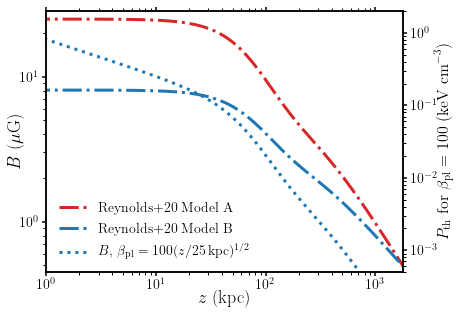

In [50]:
import numpy as np 
import alpro 
import matplotlib.pyplot as plt 
from alpro.models import unit

def B_from_P_ylim(Ptuple):
    B1 = 1e6 * np.sqrt((Ptuple[0] / pressure_conversion / beta)  * 8.0 * np.pi)
    B2 = 1e6 * np.sqrt((Ptuple[1] / pressure_conversion / beta)  * 8.0 * np.pi)
    return (B1, B2)

def beta_func(r, alpha=0.5, beta0=100, r0 = 25.0):
    beta = beta0 * (r/r0) ** alpha
    return (beta)

def make_fig1():

    beta = 100.0
    pressure_conversion = 1.0 / (1000.0 * unit.ev)

    fig, ax2 = plt.subplots()
    ax = ax2.twinx()

    models = ["1275a", "1275b"]
    label = ["A", "B"]
    color = ["C3", "C0"]
    for i, mod_name in enumerate(models):
        s = alpro.Survival(mod_name)
        s.init_model()

        r = np.logspace(-1,np.log10(2000), 1000)

        B = s.cluster.get_B(r)
        PB = (B ** 2) / 8.0 / np.pi 
        ax.plot(r, pressure_conversion * PB * beta, label="Reynolds$+$20 Model {}".format(label[i]), c=color[i], ls="-.", lw=3)

        if mod_name == "1275b":
            s.cluster.plasma_beta = beta_func
            s.init_model()
            ax2.plot(r, 1e6*s.cluster.get_B(r), ls=":", c="C0", label=r"$B$, $\beta_{\rm pl} = 100 (z/25 {\rm kpc})^{1/2}")
            ax.plot(r, s.cluster.get_B(r), ls=":", c="C0", label=r"$B,\,\beta_{\rm pl} = 100 (z/25\,{\rm kpc})^{1/2}$")


    ax.set_ylim(5e-4, 2)
    ax2.set_ylim(B_from_P_ylim(ax.get_ylim()))
    ax2.set_xlabel("$z$~(kpc)", fontsize=18, labelpad=-2)
    ax.set_ylabel(r"$P_{\rm th}~{\rm for}~\beta_{\rm pl} = 100~({\rm keV~cm}^{-3})$", fontsize=16, labelpad=-2)
    ax.legend(fontsize=14, frameon=False, loc=3)
    ax2.set_xlim(1,1800)
    ax.get_shared_y_axes().join(ax,ax2)

    ax2.set_ylabel(r"$B~(\mu {\rm G})$", fontsize=18, labelpad=-5)
    plt.loglog()
    
alpro.util.set_default_plot_params(tex=True)
make_fig1()

## Figure 3: Rotation Measures

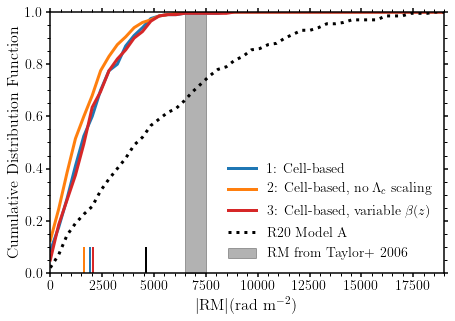

In [51]:
def get_rm_models(model_kwargs, rm_reject=False):
    N = 200
    rm = np.zeros(N)
    for i in range(N):
        s = setup_model(i, **model_kwargs)
        rm[i] = s.domain.get_rm(cell_centered=False)
    return (np.fabs(rm), np.median(np.fabs(rm)))

def setup_model(i, mod = "1275b", lc_scale = True, var_beta = False):
    s = alpro.Survival(mod)
    s.init_model()
    if var_beta:
        s.cluster.plasma_beta = beta_func
    if lc_scale == False:
        s.set_coherence_r0(None)
    s.domain.create_box_array(1800.0, i, s.coherence_func, r0=0.0)
    return (s)

ls = ["-", "-", "-", ":"]
colors = ["C0", "C1", "C3", "k"]
model = ["1275b", "1275b", "1275b", "1275a"]
labels = ["1: Cell-based", r"2: Cell-based, no $\Lambda_c$ scaling", r"3: Cell-based, variable $\beta(z)$", "R20 Model A"]
var_betas = [False, False, True, False]
lc_scales = [True, False, True, True]
imods = np.arange(len(ls))
bins = np.linspace(0,4e4,100)
params = zip(imods, model, var_betas, lc_scales, labels, colors)
fig = plt.figure()

for imod, mod, var_beta, lc_scale, label, color in params:
    model_kwargs = {"mod": mod, "var_beta": var_beta, "lc_scale": lc_scale}

    iseed = 0

    rms, median = get_rm_models(model_kwargs)
    hist, bin_edges = np.histogram(rms, bins=bins)
    cdf = np.cumsum(hist) / np.sum(hist)
    plt.plot(bin_edges[:-1], cdf, color=color, lw=3, label=labels[imod], ls = ls[imod])
    plt.vlines([median], 0, 0.1, color=color, lw=2)
    
plt.ylabel("Cumulative Distribution Function")
plt.xlabel(r"$|{\rm RM| (rad~m^{-2}})$")
plt.fill_between([6500,7500], 0, 1, color="k", alpha=0.3, label= "RM from Taylor$+$ 2006")
plt.ylim(0,1)
plt.xlim(0,19000)
plt.legend(loc=4, frameon=False)
plt.subplots_adjust(hspace=0.05, wspace=0.35, right=0.98)